In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train = pd.read_csv("/content/drive/My Drive/preprocessed_BuyAffinity_train.csv")
test = pd.read_csv("/content/drive/My Drive/preprocessed_BuyAffinity_test.csv")
print(train.shape)
print(test.shape)

(101180, 65)
(19913, 64)


<b>Remove features F10,F11,F12,F13,F14 because for each row these column has unique value and it likes the userid and itedid features.</b>

In [ ]:
class_labels = train["C"].values
test_index = test["Index"].values
train.drop(["Index","C","Unnamed: 0","F10","F11","F12","F13","F14"], axis=1, inplace=True)
test.drop(["Index","Unnamed: 0","F10","F11","F12","F13","F14"],axis=1, inplace=True)

In [ ]:
columns = list(train.columns)
columns.remove("weekday_name_F15")
columns.remove("weekday_name_F16")
print(len(columns))
print(columns)

55
['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F5_to_mean_F17', 'F5_to_mean_F18', 'F5_to_std_F17', 'F5_to_std_F18', 'F6_to_mean_F17', 'F6_to_mean_F18', 'F6_to_std_F17', 'F6_to_std_F18', 'F7_to_mean_F17', 'F7_to_mean_F18', 'F7_to_std_F17', 'F7_to_std_F18', 'F8_to_mean_F17', 'F8_to_mean_F18', 'F8_to_std_F17', 'F8_to_std_F18', 'F9_to_mean_F17', 'F9_to_mean_F18', 'F9_to_std_F17', 'F9_to_std_F18', 'F5_to_mean_weekday_name_F15', 'F5_to_mean_weekday_name_F16', 'F5_to_std_weekday_name_F15', 'F5_to_std_weekday_name_F16', 'F6_to_mean_weekday_name_F15', 'F6_to_mean_weekday_name_F16', 'F6_to_std_weekday_name_F15', 'F6_to_std_weekday_name_F16', 'F7_to_mean_weekday_name_F15', 'F7_to_mean_weekday_name_F16', 'F7_to_std_weekday_name_F15', 'F7_to_std_weekday_name_F16', 'F8_to_mean_weekday_name_F15', 'F8_to_mean_weekday_name_F16', 'F8_to_std_weekday_name_F15', 'F8_to_std_weekday_name_F16', 'F9_to_mean_weekday_name_F15', 'F9_to_mean_weekday_name_F16', 

### Spliting train data into train and test randomly. (70:30 split) 

In [ ]:
x_train, x_cv, y_train, y_cv = train_test_split(train, class_labels, test_size=0.3,random_state=42, stratify=class_labels)
print(x_train.shape)
print(y_train.shape)
print(x_cv.shape)
print(y_cv.shape)

(70826, 57)
(70826,)
(30354, 57)
(30354,)


## One hot encoding of the categorical variable Weekday_name because it has only 7 distinct values(sunday,monday,tuesday,wednesday,thursday,friday,saturday)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
countvect_F15 = CountVectorizer(binary=True)
weekday_name_F15_train = countvect_F15.fit_transform(x_train["weekday_name_F15"]. values)
weekday_name_F15_cv = countvect_F15.transform(x_cv["weekday_name_F15"]. values)
weekday_name_F15_test = countvect_F15.transform(test["weekday_name_F15"]. values)

In [ ]:
 
countvect_F16 = CountVectorizer(binary=True)
weekday_name_F16_train = countvect_F16.fit_transform(x_train["weekday_name_F16"]. values)
weekday_name_F16_cv = countvect_F16.transform(x_cv["weekday_name_F16"]. values)
weekday_name_F16_test = countvect_F16.transform(test["weekday_name_F16"]. values)

In [ ]:
columns = columns+["F15_1","F15_2","F15_3","F15_4","F15_5","F15_6","F15_7","F16_1","F16_2","F16_3","F16_4","F16_5","F16_6","F16_7"]
print(len(columns))

69


In [ ]:
x_train.drop(["weekday_name_F15","weekday_name_F16"],axis=1,inplace=True)
x_cv.drop(["weekday_name_F15","weekday_name_F16"],axis=1, inplace=True)
test.drop(["weekday_name_F15","weekday_name_F16"], axis=1, inplace=True)

In [ ]:
# Standardising the numerical variables : mean centring and variance scaling.
standardscl = StandardScaler()
xtrain_st = standardscl.fit_transform(x_train)
xcv_st = standardscl.transform(x_cv)
test_st = standardscl.transform(test)

In [ ]:
from scipy.sparse import hstack
x_train = hstack((xtrain_st,weekday_name_F15_train,weekday_name_F16_train))
x_cv = hstack((xcv_st,weekday_name_F15_cv,weekday_name_F16_cv))
test = hstack((test,weekday_name_F15_test,weekday_name_F16_test))

In [ ]:
 # for ploting confusing matrix , precision matrix and recall matrix.
from sklearn.metrics import confusion_matrix
 
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(5,5))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
 
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(5,5))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(5,5))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## **Logistic Regression Model :**

In [ ]:
 
param = {"alpha":[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
clf = SGDClassifier(loss="log", class_weight='balanced', penalty="l2")
rand_clf = RandomizedSearchCV(clf, param, scoring="roc_auc", return_train_score=True)
rand_clf.fit(x_train, y_train)
print(rand_clf.best_params_)
print("="*100)
print(rand_clf.best_estimator_)

{'alpha': 0.01}
SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
 
print(rand_clf.cv_results_["mean_train_score"])
print(rand_clf.cv_results_["mean_test_score"])

[0.66949861 0.68478986 0.68726834 0.68167559 0.6776229  0.67616066
 0.67577167 0.67571963 0.67571499]
[0.66892145 0.6840564  0.68493525 0.67997524 0.67615378 0.67428009
 0.67375942 0.67368875 0.67368361]


In [ ]:
 
clf_lr = SGDClassifier(loss="log", class_weight="balanced", alpha=rand_clf.best_params_["alpha"], penalty="l2")
clf_lr.fit(x_train, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Train AUC = 0.6875231172281493
-------------------- Confusion matrix --------------------


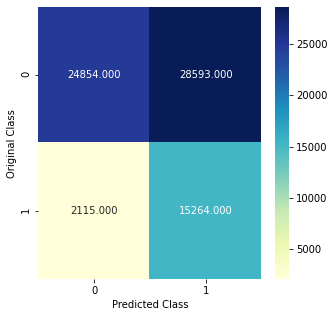

-------------------- Precision matrix (Columm Sum=1) --------------------


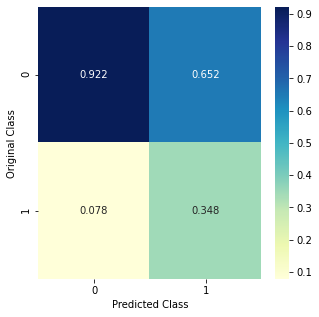

-------------------- Recall matrix (Row sum=1) --------------------


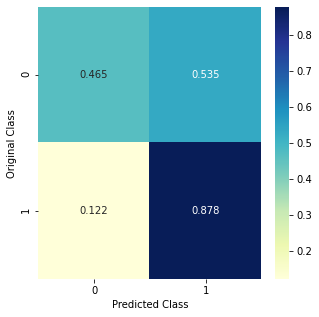

In [ ]:
 
pred = clf_lr.predict(x_train)
pred_prob = clf_lr.predict_proba(x_train)
print("Train AUC =",roc_auc_score(y_train, pred_prob[:,1]))
print("="*100)
plot_confusion_matrix(y_train, pred)

<b>For train data</b>

precision for class-0 points is high and for class-1 is low because the dataset is highly imbalanced.

Recall for class-0 is very low and recall for class-1 is high

CV AUC = 0.6847421554659998
-------------------- Confusion matrix --------------------


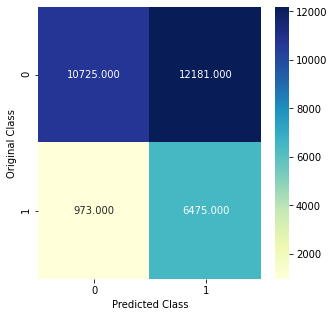

-------------------- Precision matrix (Columm Sum=1) --------------------


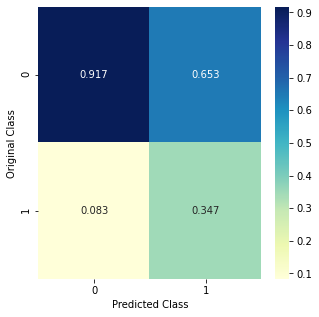

-------------------- Recall matrix (Row sum=1) --------------------


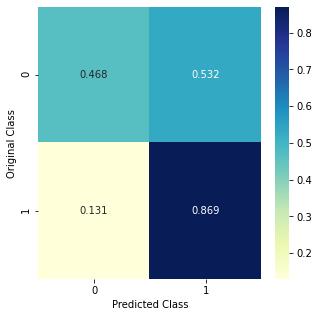

In [ ]:
 
pred = clf_lr.predict(x_cv)
pred_prob = clf_lr.predict_proba(x_cv)
print("CV AUC =",roc_auc_score(y_cv, pred_prob[:,1]))
print("="*100)
plot_confusion_matrix(y_cv, pred)

<b>For CV data</b>

precision for class-0 is very high and for class-1 is very low.

and recall for class-0 datapoints is very low and recall for class-1 datapoints is high.

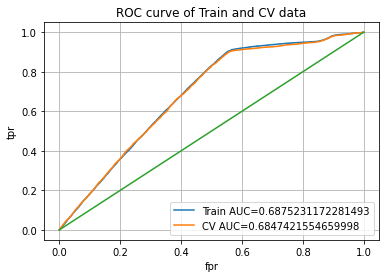

In [ ]:
# ploting ROC AUC curve
pred_train = clf_lr.predict(x_train)
pred_prob_train = clf_lr.predict_proba(x_train)
pred_cv = clf_lr.predict(x_cv)
pred_prob_cv = clf_lr.predict_proba(x_cv)
 
train_fpr,train_tpr,tr_thresholds=roc_curve(y_train, pred_prob_train[:,1])
test_fpr,test_tpr,te_thresholds=roc_curve(y_cv, pred_prob_cv[:,1])
plt.plot(train_fpr,train_tpr,label="Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="CV AUC="+str(auc(test_fpr,test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])
plt.title("ROC curve of Train and CV data")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

The Auc score is good and the best thing is that this model is not overfit. And the AUC score is average but not very well, actually performance metrics also depends on the business requirement.

## **Feature Importance :**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

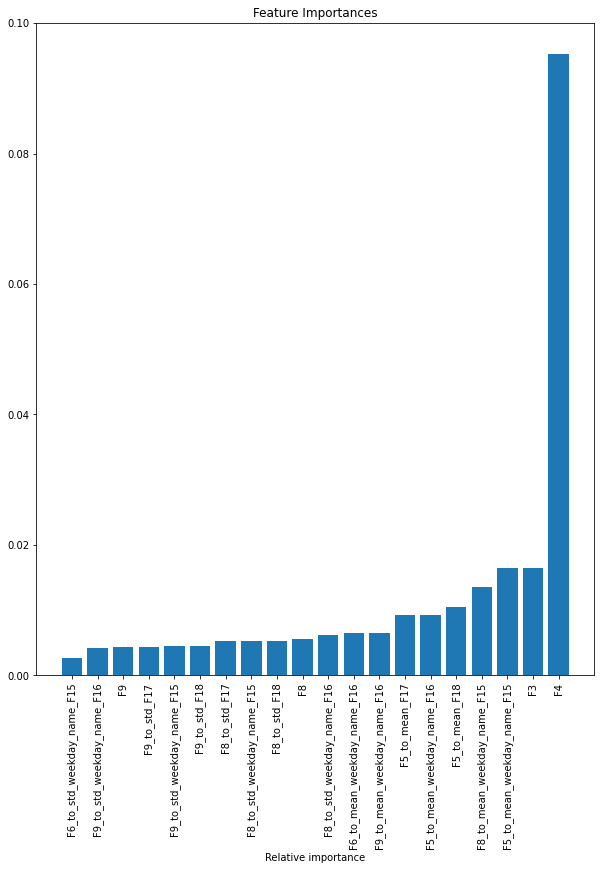

In [ ]:
#ploting top 20 important features :
features = columns
importances = clf_lr.coef_.reshape(-1, )
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.xticks(rotation=90)

It shows that engineered features are very important for Logistic regression model.

## **Random Forest Model :**

In [101]:
param = {"n_estimators":[100,300,500,600,800,1100], 'max_depth':[1,3,4,5]}

clf = RandomForestClassifier(class_weight='balanced')
rand_clf = RandomizedSearchCV(clf, param, scoring="roc_auc", return_train_score=True)
rand_clf.fit(x_train, y_train)
print(rand_clf.best_params_)
print("="*60)
print(rand_clf.best_estimator_)

{'n_estimators': 800, 'max_depth': 5}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [102]:
print(rand_clf.cv_results_["mean_train_score"])
print("="*100)
print(rand_clf.cv_results_["mean_test_score"])

[0.72644952 0.7093848  0.71204554 0.69943051 0.70051334 0.72610442
 0.72640248 0.71112631 0.69841461 0.71269111]
[0.69597518 0.69244806 0.69224199 0.68610984 0.68755597 0.6959105
 0.69605191 0.69217063 0.68619156 0.69274021]


In [103]:
clf_rf = RandomForestClassifier(n_estimators=800,max_depth=5,class_weight='balanced')
clf_rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train AUC = 0.7225617093970684
-------------------- Confusion matrix --------------------


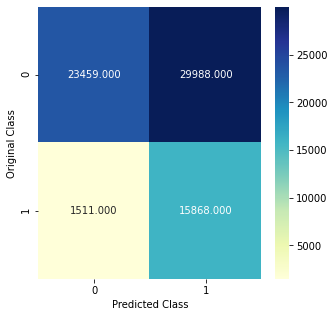

-------------------- Precision matrix (Columm Sum=1) --------------------


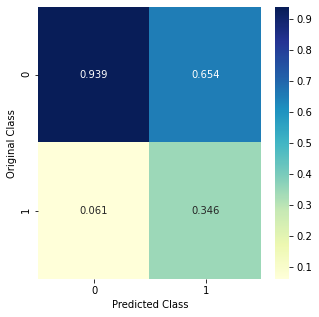

-------------------- Recall matrix (Row sum=1) --------------------


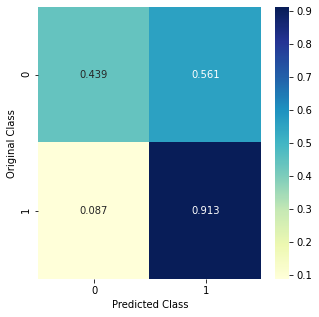

In [104]:
pred_train = clf_rf.predict(x_train)
pred_prob_train = clf_rf.predict_proba(x_train)
pred_cv = clf_rf.predict(x_cv)
pred_prob_cv = clf_rf.predict_proba(x_cv)
print("Train AUC =",roc_auc_score(y_train, pred_prob_train[:,1]))
print("="*100)
plot_confusion_matrix(y_train, pred_train)

CV AUC = 0.6935263691059609
-------------------- Confusion matrix --------------------


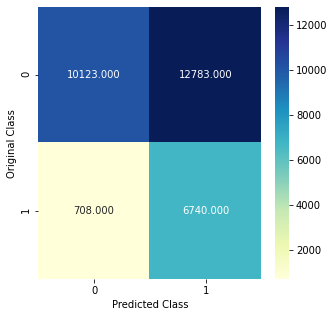

-------------------- Precision matrix (Columm Sum=1) --------------------


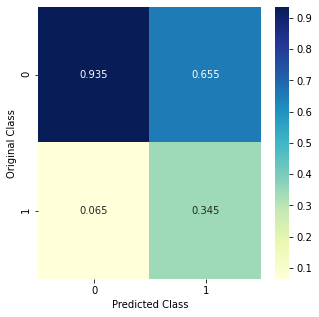

-------------------- Recall matrix (Row sum=1) --------------------


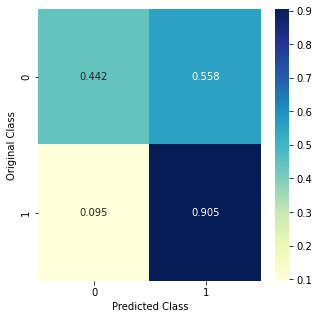

In [105]:
print("CV AUC =",roc_auc_score(y_cv, pred_prob_cv[:,1]))
print("="*100)
plot_confusion_matrix(y_cv, pred_cv)

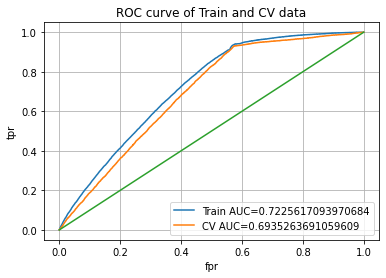

In [106]:
train_fpr,train_tpr,tr_thresholds=roc_curve(y_train, pred_prob_train[:,1])
test_fpr,test_tpr,te_thresholds=roc_curve(y_cv, pred_prob_cv[:,1])
plt.plot(train_fpr,train_tpr,label="Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="CV AUC="+str(auc(test_fpr,test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])
plt.title("ROC curve of Train and CV data")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

Random forest model performed slightly better than Logistic Regression model.

## Feature importance :

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

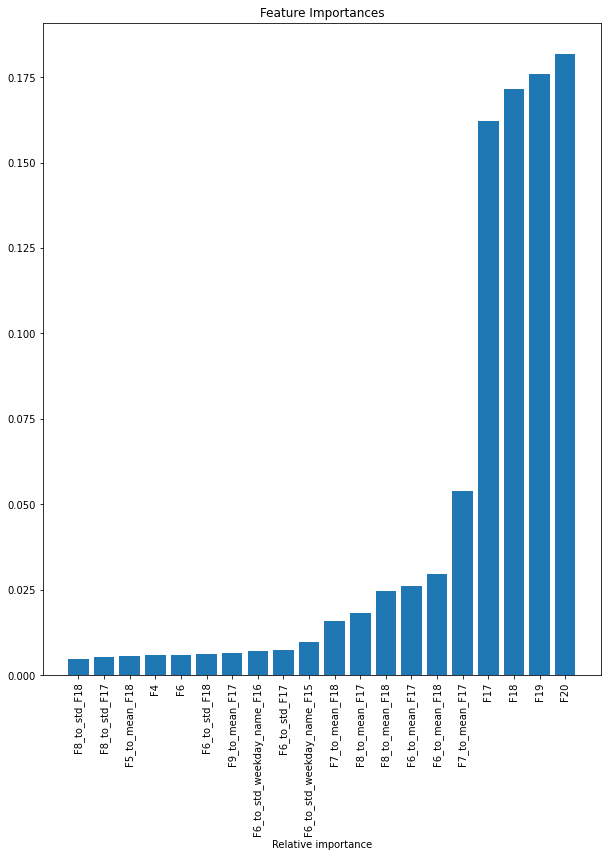

In [107]:
features = columns
importances = clf_rf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.xticks(rotation=90)

It shows that some engineered features are very important for the Random Forest model, but some of the actual given features are very impotant, we need to do some more experiment with feature engineering to increase the AUC score.

## **Applying LGBMClassifier model, because it is super fast than XGBoost model :**

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'max_depth':[1,3,4,5],
             'learning_rate':[0.001,0.01,0.1], 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'n_estimators':[100,300,500,600,800,1100],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 12]}

In [ ]:
clf = LGBMClassifier(class_weight='balanced')
rand_clf = RandomizedSearchCV(clf, param_test, scoring="roc_auc", return_train_score=True)
rand_clf.fit(x_train, y_train)
print(rand_clf.best_params_)
print("="*60)
print(rand_clf.best_estimator_)

{'learning_rate': 0.01, 'max_depth': 4, 'min_child_samples': 241, 'min_child_weight': 10.0, 'n_estimators': 300, 'reg_alpha': 7, 'reg_lambda': 10, 'subsample': 0.9616943350633742}
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=4, min_child_samples=241,
               min_child_weight=10.0, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=7, reg_lambda=10, silent=True,
               subsample=0.9616943350633742, subsample_for_bin=200000,
               subsample_freq=0)


In [ ]:
print(rand_clf.cv_results_["mean_train_score"])
print("="*100)
print(rand_clf.cv_results_["mean_test_score"])

[0.74505019 0.72412676 0.69955677 0.7183886  0.71616195 0.76178873
 0.71320537 0.75044872 0.75535632 0.79477825]
[0.7030523  0.70446955 0.69053661 0.70655752 0.70491034 0.70337872
 0.70415257 0.70299134 0.70365671 0.69696885]


In [ ]:
clf_lgbm = LGBMClassifier(class_weight="balanced", max_depth=4, min_child_samples=241, min_child_weight=10.0, n_estimators=300, reg_alpha=7, reg_lambda=10, subsample=0.9617, learning_rate=0.01)
clf_lgbm.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=4, min_child_samples=241,
               min_child_weight=10.0, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=7, reg_lambda=10, silent=True, subsample=0.9617,
               subsample_for_bin=200000, subsample_freq=0)

Train AUC = 0.7163609951423086
-------------------- Confusion matrix --------------------


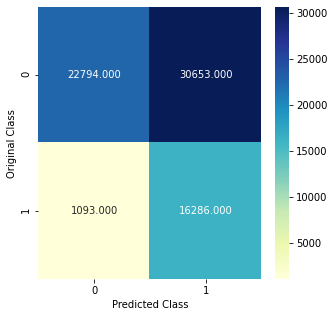

-------------------- Precision matrix (Columm Sum=1) --------------------


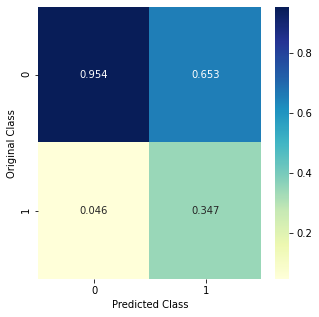

-------------------- Recall matrix (Row sum=1) --------------------


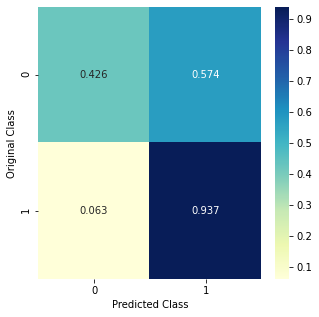

In [ ]:
pred_train = clf_lgbm.predict(x_train)
pred_prob_train = clf_lgbm.predict_proba(x_train)
pred_cv = clf_lgbm.predict(x_cv)
pred_prob_cv = clf_lgbm.predict_proba(x_cv)
print("Train AUC =",roc_auc_score(y_train, pred_prob_train[:,1]))
print("="*100)
plot_confusion_matrix(y_train, pred_train)

<b>For Train data :</b>

precision for class-0 datapoints is very high but for class-1 data is low and Recall for class-0 datapoints is low but recall for class-1 datapoints is high.

CV AUC = 0.7026327530120533
-------------------- Confusion matrix --------------------


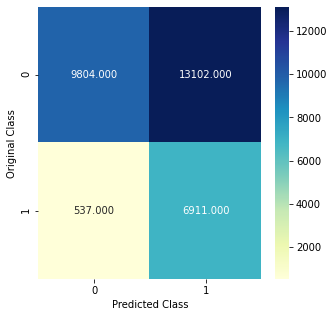

-------------------- Precision matrix (Columm Sum=1) --------------------


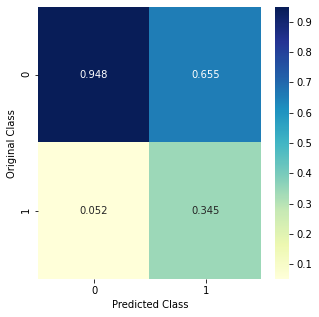

-------------------- Recall matrix (Row sum=1) --------------------


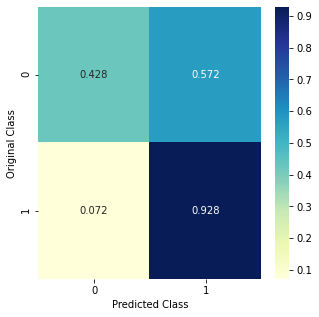

In [ ]:
print("CV AUC =",roc_auc_score(y_cv, pred_prob_cv[:,1]))
print("="*100)
plot_confusion_matrix(y_cv, pred_cv)

<b>For CV data :</b>

precision for class-0 datapoints is very high but for class-1 data is low 
and 
Recall for class-0 datapoints is low but recall for class-1 datapoints is high.

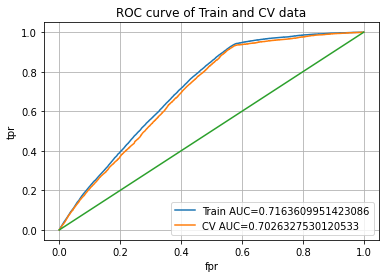

In [ ]:
train_fpr,train_tpr,tr_thresholds=roc_curve(y_train, pred_prob_train[:,1])
test_fpr,test_tpr,te_thresholds=roc_curve(y_cv, pred_prob_cv[:,1])
plt.plot(train_fpr,train_tpr,label="Train AUC="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="CV AUC="+str(auc(test_fpr,test_tpr)))
plt.plot([0.0,1.0],[0.0,1.0])
plt.title("ROC curve of Train and CV data")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

The Auc score is good and the best thing is that this model is not overfit.
And the AUC score is average but not very well, actually performance metrics also depends on the business requirement.

## **Feature Importance :**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

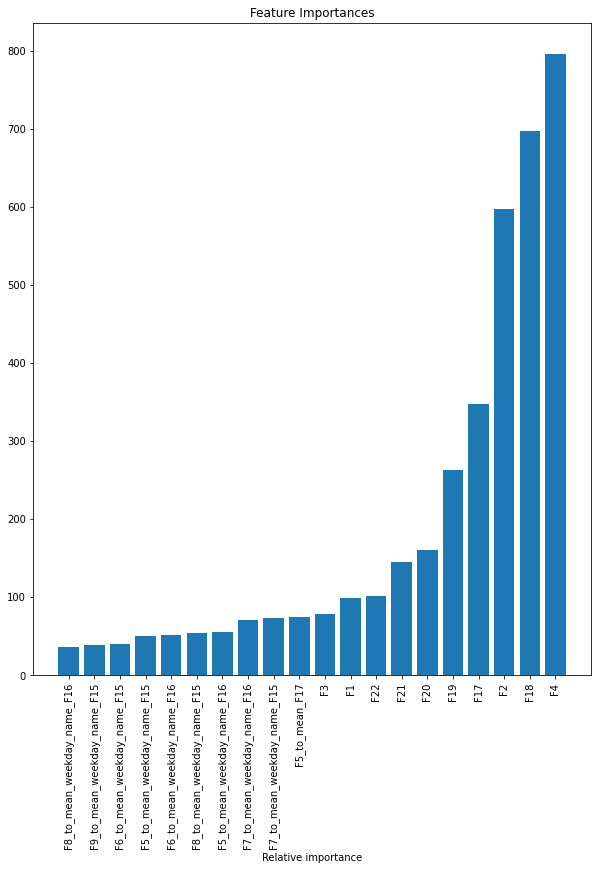

In [ ]:
features = columns
importances = clf_lgbm.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.xticks(rotation=90)

It shows that some engineered features are very important for the LGBM model, but some of the actual givel features are very impotant, we need to do some more experiment with feature engineering to increase the AUC score.

## **Summary(PrettyTable) :**

In [108]:
from prettytable import PrettyTable
table = PrettyTable(["Model","Train AUC score","CV AUC score"])
table.add_row(["Logistic Regression",0.6875,0.6847])
table.add_row(["Random Forest",0.7225,0.6935])
table.add_row(["LGBMClassifier",0.7164,0.7027])
print(table)

+---------------------+-----------------+--------------+
|        Model        | Train AUC score | CV AUC score |
+---------------------+-----------------+--------------+
| Logistic Regression |      0.6875     |    0.6847    |
|    Random Forest    |      0.7225     |    0.6935    |
|    LGBMClassifier   |      0.7164     |    0.7027    |
+---------------------+-----------------+--------------+


LGBMClassifier and Ranadom Forest models perform slightly well because it is non-linear model and it perform very well on less dimentional dataset.

Here the winner is LGBM model

In [ ]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file to drive.
joblib.dump(clf_lgbm, '/content/drive/My Drive/BuyAffinity_lgbm_model.pkl')

['/content/drive/My Drive/BuyAffinity_lgbm_model.pkl']

In [ ]:
pred_test = clf_lgbm.predict(test)

In [ ]:
sample_sub = pd.DataFrame(data = {"Index":test_index,"C":pred_test})
sample_sub.to_csv("/content/drive/My Drive/sample_submission_buyAffinity.csv",index=False)